In [80]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as la
rng = np.random.default_rng(3)
plt.style.use('dark_background')

In [81]:
def produc_vec(n, len):
    vec = rng.uniform(-1,1,(n,2))
    vec = len*vec/la.norm(vec, axis=1).reshape(-1,1)
    return vec

In [102]:
num_vecs = 3
vec0 = np.array([[0,0],[-1,1],[1,1]])#produc_vec(num_vecs, 15)
vec1_ls = []
vec2_ls = []
n1, n2 = 6, 4
for i in range(n1):
    vec1_ls.append(vec0 + produc_vec(len(vec0), .5) ) 
vec1 = np.concatenate(vec1_ls, axis=0)
for i in range(n2):
    vec2_ls.append(vec1 + produc_vec(len(vec1), .1) ) 
vec2 = np.concatenate(vec2_ls, axis=0)

In [103]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors = default_colors[1:num_vecs+1]
colors1 = default_colors*n1#colors1.tolist()
colors2 = default_colors*(n1*n2)

(-1.7254717667038437,
 1.6706952424004706,
 -0.6152348142538262,
 1.6223890275712516)

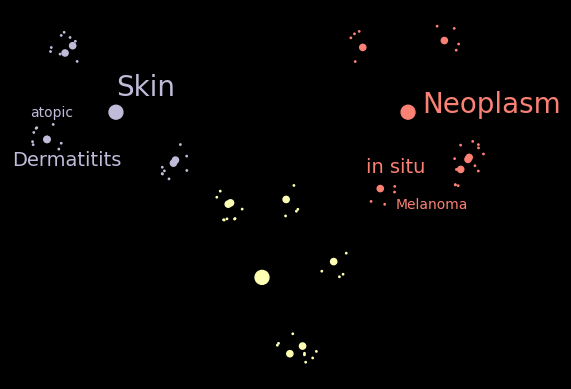

In [161]:
fig, ax = plt.subplots()
ax.scatter(vec0[:,0], vec0[:,1], s=100, c=default_colors)
ax.scatter(vec1[:,0], vec1[:,1], s=20, c=colors1)
ax.scatter(vec2[:,0], vec2[:,1], s=1, c=colors2)
# annotate vec0
ax.annotate('Neoplasm', (vec0[2,0]+.1, vec0[2,1]), fontsize=20, color=default_colors[2])
ax.annotate('in situ', (vec1[8,0]-.1, vec1[8,1]+.1), fontsize=14, color=default_colors[2])
ax.annotate('Melanoma', (vec2[8,0]+.01, vec2[8,1]-.1), fontsize=10, color=default_colors[2])

ax.annotate('Skin', (vec0[1,0], vec0[1,1]+.1), fontsize=20, color=default_colors[1])
ax.annotate('Dermatitits', (vec1[7,0]-.24, vec1[7,1]-.16), fontsize=14, color=default_colors[1])
ax.annotate('atopic', (vec2[7,0]-.16, vec2[7,1]+.05), fontsize=10, color=default_colors[1])


plt.axis('off')